    Sean Gies
    s4783670
    14 - 10 - 2020

In this assignment you will learn to implement neural q learning. You will learn to control a Brownian particle from noisy observations. The goal of the agent is to bring the particle as close as possible to zero. All code is provided except the learning part. Your goal is to implement the learn function of the QAgent. The plotting functions in the end should indicate that indeed the agent learns to control the particle's location.

$\textbf{SARSA}$ algorithm

$$Q(S_t, A_t) <- Q(S_t,A_t) + \alpha[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]$$

$\textbf{Temporal difference}$ mean-squared error

$$\mathcal{L(\theta)} = \mathbb{E}[(r_{t+1} + \gamma \max_{a}Q(S_{t+1}, a) - Q(S_t, A_t))^2]$$

### Notes


+ If we ignore the epsilon-greedy strategy and simply take the best action for every state in the learn() function of the Q-agent then our agent performs very well, with the loss dropping to 0 in under 500 steps.

---

+ Taking the label for the L2loss function as Q[action] tends to cause the final graph to show arrows pointing towards 0 but only from one side ( either left or right )

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import gym
import mxnet as mx
from mxnet import autograd, gluon, nd, init
from mxnet.gluon import nn, Block
from mxnet.gluon.nn import LeakyReLU

In [2]:

class ControlledBrownianMotion(gym.Env):
    """
    Implements controlled Brownian motion in n dimensions

    For OpenAI gym see:
    
    https://github.com/openai/gym/blob/master/gym/core.py
    https://gym.openai.com/docs/#spaces

    """

    def __init__(self, n_dim = 1, state_noise=1.0, obs_noise=1.0, act_mag=1.0):

        self.n_dim = n_dim

        # state space is R^n
        self.state_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(n_dim,), dtype=np.float32)

        # state space is R^n
        self.obs_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(n_dim,), dtype=np.float32)

        # action space is a discrete choice of 0 'left', 1 'stay' and 2 'right' per dimension
        self.action_space = gym.spaces.Discrete(3**n_dim)

        # current state of the particle
        self.state = self.state_space.sample()

        # variance of the state update in each dimension
        self.state_noise = state_noise

        # variance of the observation in each dimension
        self.obs_noise = obs_noise

        # magnitude of the action
        self.act_mag = act_mag

    def reset(self):

        self.state = self.state_space.sample()
        
        return self.observe(self.state, None)

    def observe(self, state, action):
        """
            Observation is a draw from a MVN with mean state and diagonal covariance
        """
        
        if self.obs_noise > 0.0:
            return np.atleast_2d(np.random.multivariate_normal(self.state, self.obs_noise * np.eye(self.n_dim)))
        else:
            return np.atleast_2d(self.state)

    def step(self, action):
        
        if self.state_noise > 0.0:
            self.state = np.random.multivariate_normal(self.state, self.state_noise * np.eye(self.n_dim))

        self.state = self.state + self.act_mag * (np.array(np.unravel_index(action, [3] * self.n_dim)) - 1)

        obs = self.observe(self.state, action)

        reward = - np.linalg.norm(self.state)

        return obs, reward, False, None

    def render(self, mode='human'):
        pass

In [3]:
class Agent():
    """
    Base class for reinforcement learning agents
    """

    def __init__(self, env = None):

        self.env = env

    def act(self, obs):
        return self.env.action_space.sample() # sample random action

    def learn(self, obs, action, reward, new_obs):
        pass

    def reset(self):
        pass

class QNetwork(gluon.nn.Block):
    """
    Neural network to predict q values from observations
    """

    def __init__(self, n_hidden, n_actions):
        super().__init__()

        self.dense0 = gluon.nn.Dense(n_hidden, activation='relu')
        self.dense1 = gluon.nn.Dense(n_actions)

    def forward(self, state):
        """
        return
        ------
            an action value indicating the expected future reward for each action
        """
        return self.dense1(self.dense0(state))

class QAgent(Agent):
    """
    Agent that implements q learning
    """

    def __init__(self, env, model, ctx=mx.cpu(), learning_rate=0.01, gamma=0.95, init_epsilon=1.0, eps=0.01):
        super().__init__(env)

        # set model
        self.model = model
        
        # set loss function
        self.loss = gluon.loss.L2Loss()

        # setup an optimizer
        self.optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})

        # discounting factor
        self.gamma = gamma
        
        # learning rate
        self.learning_rate = learning_rate

        # epsilon greedy
        self.init_epsilon = init_epsilon
        self.epsilon = init_epsilon
        self.eps = eps

    def act(self, obs):

        if np.random.rand() < self.epsilon:
             # epsilon greedy
            action = env.action_space.sample()
        else:            
            # Choose action with maximal q value
            action = np.argmax(self.model(nd.array(obs, ctx=ctx)).asnumpy())

        self.epsilon = np.max([0.0, self.epsilon - self.eps])

        return action

    def learn(self, obs, action, reward, new_obs):
        """
        You will need to implement this function. That is compute the temporal difference error and perform gradient descent on this.
        
        Because of epsilon-greedy strat we don't always take the action with the max-q value for the current state
        
        Parameters
        ----------
            obs     : (1,1) : observation at t
            action  : Int   : action taken from obs -> new_obs
            reward  : ()    : reward at t+1
            new_obs : (1,1) : observation at t+1
        Return
        ------
            loss : L2 (mean-squared) loss between predicted state and actual state
        """        
        with autograd.record():
            ## q value of current state (3 values)
            q_t = self.model.forward(mx.ndarray.array(obs))
            
            # take the q-value for the given action
            q_t = q_t[0][action]

            ## q value of next state (3 values)
            q_t2 = self.model.forward(mx.ndarray.array(new_obs)) 

            ## action with max value
            max_a = np.max(q_t2)

            ## expected loss equation between current state and next state
            L = (reward + self.gamma * max_a - q_t)**2
        
            ## L2loss between current state (label) and expected loss next step (prediction)
            l = self.loss(L, q_t) 
            
        # gradient descent backwards pass
        l.backward()
        self.optimizer.step(300) # parameter: batch_size

        # need to convert from mxnet array to numpy array for plotting purposes
        return l.asnumpy()[0]

    def reset(self):
        self.epsilon = self.init_epsilon

In [4]:
seed = 3333333
np.random.seed(seed)
mx.random.seed(seed)

buffer = {}
buffer['state'] = []
buffer['observation'] = []
buffer['action'] = []
buffer['reward'] = []
buffer['loss'] = []

# epsilon-greedy parameters : decreases over time to facilitate exploitation
init_epsilon=1.0
final_epsilon=0.01
T=5000

ctx = mx.cpu()

# initilise the brownian random motion environment
env = ControlledBrownianMotion(n_dim=1, state_noise=0.1, obs_noise=0.1, act_mag=1.0)

# initilise the Qnetwork 
model = QNetwork(n_hidden=20, n_actions=3**env.n_dim)
model.initialize(ctx=ctx)

# initilise the agent
agent = QAgent(env, model, ctx=ctx, learning_rate=0.001, gamma=0.95, init_epsilon=init_epsilon, eps = (init_epsilon - final_epsilon) / T)

obs = env.reset()
agent.reset()
for t in tqdm.trange(T):

    env.render()
    
    # select action
    action = agent.act(obs)

    # Perform the selected action, get the reward, and a new observation for the next round
    new_obs, reward, done, info = env.step(action)
    
    # Adjust agent parameters (training step)
    loss = agent.learn(obs, action, reward, new_obs)

    buffer['state'].append(env.state)
    buffer['observation'].append(obs)
    buffer['action'].append(action)
    buffer['reward'].append(reward)
    buffer['loss'].append(loss)

    # Update observation variable
    obs = new_obs

    if done:
        break
        

env.close()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 187.04it/s]


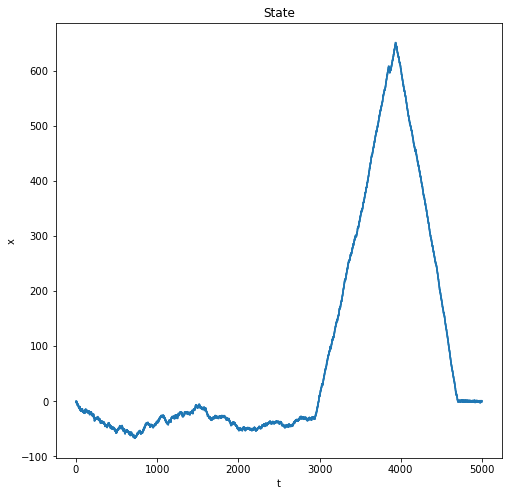

In [5]:
# plot states

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for t in range(len(buffer['state'])-1):
    x1 = buffer['state'][t][0]
    x2 = buffer['state'][t+1][0]
    ax.plot([t, t+1], [x1, x2], 'C0')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('State');

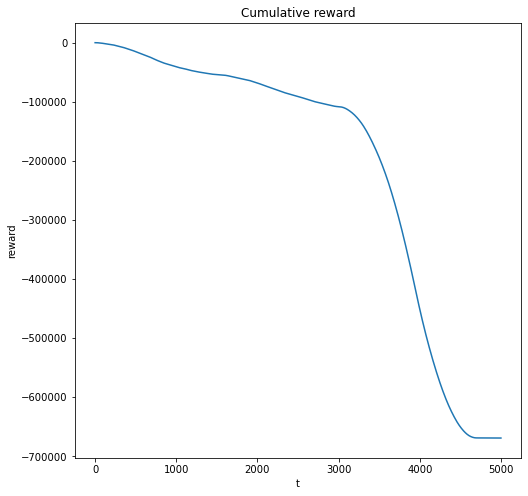

In [6]:
# plot reward

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(np.cumsum(buffer['reward']))
ax.set_title('Cumulative reward')
ax.set_xlabel('t')
ax.set_ylabel('reward');

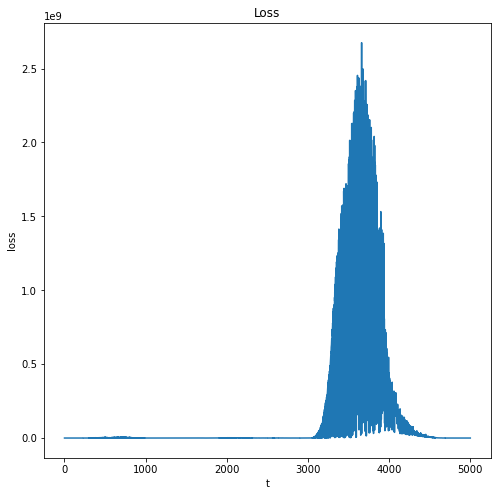

In [7]:
# plot loss

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(buffer['loss'])
ax.set_title('Loss')
ax.set_xlabel('t')
ax.set_ylabel('loss');

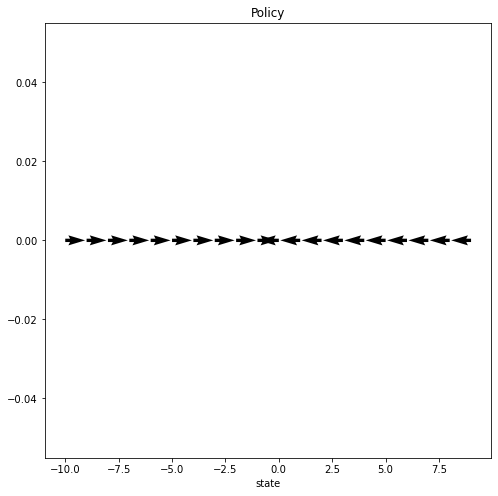

In [8]:
# plot policy

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n=10
x = np.arange(-n, n, 1)
u = np.zeros(x.size)
for i in range(x.size):
    qvalues = model(nd.array([x[i]], ctx=ctx))
    action = env.act_mag * (np.array(np.unravel_index(np.argmax(qvalues.asnumpy(), axis=1), [3] * env.n_dim)) - 1)
    u[i] = action[0]
ax.quiver(x, 0, u, 0, scale=1.5, units='xy')
ax.set_title('Policy')
ax.set_xlabel('state');